In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Wed Jan 17 17:50:50 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   35C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.normal_prior import Prior
from model.latent.mmd_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.activation = F.sigmoid
hp.opts = {'pz_scale': 1,
           'mmd_kernel': 'IMQ', # 'IMQ', 'RBF'
            'pz': 'normal', # 'normal', 'sphere', 'uniform'
            'zdim': hp.z_dim
           }

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(10):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.99169921875
encoder.convs 5.9912109375
encoder.linear 1.00048828125
prior 0.0
latent 0.0
decoder 7.028697967529297
decoder.linear 1.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_celeba/train01.17-3/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 462316
-rw-rw-r-- 1 scpark scpark    130244  1월 17 17:50 events.out.tfevents.1705480727.GPUSVR11
-rw-rw-r-- 1 scpark scpark 473276127  1월 17 17:39 save_0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_transforms = transforms.Compose([transforms.CenterCrop(148),
                                      transforms.Resize(hp.size),
                                      transforms.ToTensor(),])
test_dataset = MyCelebA(root, split='test', transform=test_transforms, download=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

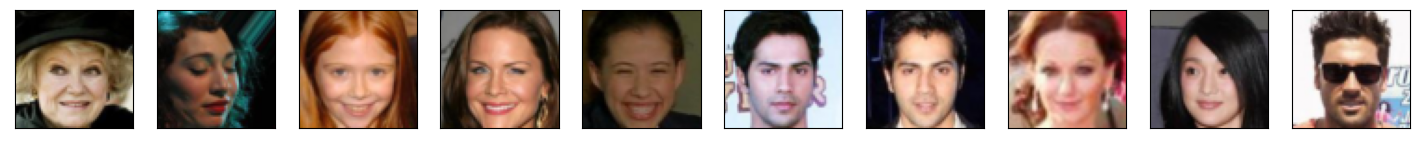

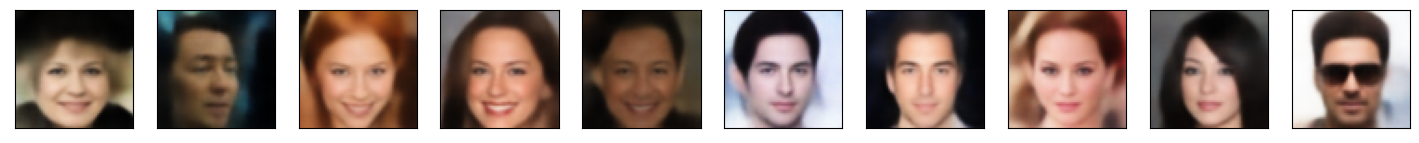

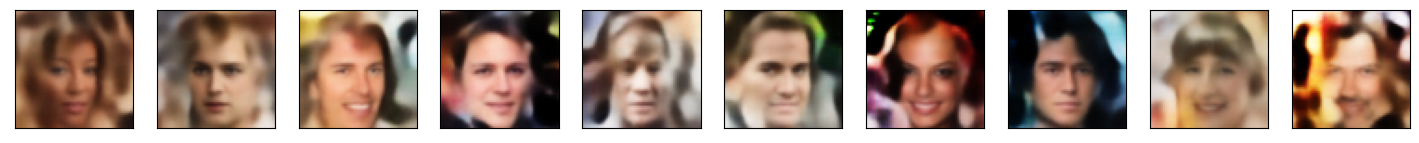

200001
mmd_loss -0.0023309946060180663
recon_loss 0.005032601114362478
200002
mmd_loss -0.0025131866335868836
recon_loss 0.005387201672419906
200003
mmd_loss -0.0028685972094535826
recon_loss 0.005270033935084939
200004
mmd_loss -0.002609647810459137
recon_loss 0.005601878324523568
200005
mmd_loss -0.0027803421020507813
recon_loss 0.005110745038837195
200006
mmd_loss -0.003122308850288391
recon_loss 0.005132359964773059
200007
mmd_loss -0.002269844710826874
recon_loss 0.00525745046325028
200008
mmd_loss -0.002978514134883881
recon_loss 0.005180288711562753
200009
mmd_loss -0.002478078007698059
recon_loss 0.005260336073115468
200010
mmd_loss -0.0022393181920051576
recon_loss 0.005213773669674992
200011
mmd_loss -0.0028739556670188903
recon_loss 0.005282609304413199
200012
mmd_loss -0.0026348963379859923
recon_loss 0.005280033359304071
200013
mmd_loss -0.002658642828464508
recon_loss 0.005287285801023245
200014
mmd_loss -0.0030094310641288757
recon_loss 0.005430893041193485
200015
mmd_lo

mmd_loss -0.0022825941443443297
recon_loss 0.005198227660730481
200118
mmd_loss -0.0023631662130355834
recon_loss 0.005404156725853681
200119
mmd_loss -0.002441534399986267
recon_loss 0.0048361191060394045
200120
mmd_loss -0.0028579428791999815
recon_loss 0.005180802009999752
200121
mmd_loss -0.003156018257141113
recon_loss 0.005080865556374192
200122
mmd_loss -0.0027841344475746156
recon_loss 0.004991938965395093
200123
mmd_loss -0.0025612682104110716
recon_loss 0.005219438578933477
200124
mmd_loss -0.003018315136432648
recon_loss 0.00530905332416296
200125
mmd_loss -0.0023917511105537416
recon_loss 0.005374571634456515
200126
mmd_loss -0.0029018864035606383
recon_loss 0.004980080621317029
200127
mmd_loss -0.002496221661567688
recon_loss 0.005083854822441935
200128
mmd_loss -0.00295422226190567
recon_loss 0.005075831338763237
200129
mmd_loss -0.002516533434391022
recon_loss 0.0051698589231818914
200130
mmd_loss -0.0027913033962249758
recon_loss 0.005267373379319906
200131
mmd_loss -0.

mmd_loss -0.0027693137526512146
recon_loss 0.005084434198215604
200234
mmd_loss -0.0029607608914375303
recon_loss 0.005388368107378483
200235
mmd_loss -0.002381102740764618
recon_loss 0.005159842409193515
200236
mmd_loss -0.0026827707886695864
recon_loss 0.005347396060824394
200237
mmd_loss -0.002236969769001007
recon_loss 0.0050708092749118805
200238
mmd_loss -0.002409234642982483
recon_loss 0.00507434019818902
200239
mmd_loss -0.0027755483984947204
recon_loss 0.00533469351939857
200240
mmd_loss -0.002793194353580475
recon_loss 0.005273845233023167
200241
mmd_loss -0.0028679326176643373
recon_loss 0.0050665117800235745
200242
mmd_loss -0.0027145132422447204
recon_loss 0.0051100034266710285
200243
mmd_loss -0.002616085112094879
recon_loss 0.005089586740359664
200244
mmd_loss -0.002508707344532013
recon_loss 0.0051926641259342435
200245
mmd_loss -0.0028576865792274476
recon_loss 0.005096657620742917
200246
mmd_loss -0.0024245023727416993
recon_loss 0.005482437741011381
200247
mmd_loss -

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=len(data['x']))

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=len(data['x']))
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = model.prior.sample(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [12]:
save_model_list(save_dir, step, model_list, optimizer_list)
print(step)

199647
